# Regression problem

The task is to predict the median price of a house on a given district in California, given past records on sold properties in this US state.

In [1]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

sns.set_theme(palette="Set2")

# Load the data

In [2]:
import os
import tarfile
import urllib


# the file is archived with tar and gunzip
URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"

def get_dataframe():
    global URL
    
    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # if the archived file does not exist, download it
    if not os.path.exists("datasets/housing.tgz"):
        urllib.request.urlretrieve(URL, "datasets/housing.tgz")
    
    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/housing.csv"):
        infile = tarfile.open("datasets/housing.tgz")
        infile.extractall(path="datasets")
        infile.close()
    
    # load the dataframe
    return pd.read_csv("datasets/housing.csv")

In [3]:
df = get_dataframe()

In [4]:
# inspect the first couple of rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# the size of the dataset
df.shape

(20640, 10)

# Train-test split

In [6]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

In [7]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=7,
                                     stratify=df["income_cat"])

In [8]:
del trainset["income_cat"]
del testset["income_cat"]

# Feature engineering

In [9]:
# create two new features
trainset["rooms_per_household"] = trainset["total_rooms"]/trainset["households"]
trainset["population_per_household"] = trainset["population"]/trainset["households"]

In [10]:
corr_matrix = trainset.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686289
rooms_per_household         0.147401
total_rooms                 0.135723
housing_median_age          0.109030
households                  0.066404
total_bedrooms              0.050819
population_per_household   -0.021876
population                 -0.024405
longitude                  -0.045513
latitude                   -0.145896
Name: median_house_value, dtype: float64

In [11]:
testset["rooms_per_household"] = testset["total_rooms"]/testset["households"]
testset["population_per_household"] = testset["population"]/testset["households"]

In [12]:
# rename "ISLAND" to "NEAR OCEAN"
trainset["ocean_proximity"] = trainset["ocean_proximity"].replace("ISLAND", "NEAR OCEAN")
testset["ocean_proximity"] = testset["ocean_proximity"].replace("ISLAND", "NEAR OCEAN")
trainset["ocean_proximity"].unique()

array(['NEAR OCEAN', 'NEAR BAY', 'INLAND', '<1H OCEAN'], dtype=object)

In [13]:
# delete capped values
    
print(f"Before: {trainset.shape[0]} train instances, {testset.shape[0]} test instances")

trainset.drop(trainset[trainset["median_house_value"] >= 500001].index, inplace=True)
testset.drop(testset[testset["median_house_value"] >= 500001].index, inplace=True)

print(f"After: {trainset.shape[0]} train instances, {testset.shape[0]} test instances")

Before: 16512 train instances, 4128 test instances
After: 15735 train instances, 3940 test instances


# Dummy variables

In [14]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(drop="first", sparse=False)

In [15]:
# categorical columns to transform
cat_cols = ["ocean_proximity"]

# fit an encoder and transform the **trainset**
cat_vals = trainset[cat_cols]
cat_vals

,ocean_proximity
8088,NEAR OCEAN
15259,NEAR OCEAN
710,NEAR BAY
12828,INLAND
1327,INLAND
...,...
8285,NEAR OCEAN
20569,INLAND
12632,INLAND
5135,<1H OCEAN


In [16]:
transformed = one_hot_encoder.fit_transform(cat_vals)
transformed

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.]])

In [17]:
# the names of the new columns are the unique values of "ocean_proximity"
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)
new_col_names

array(['ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [18]:
# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    trainset[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the trainset
trainset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,139300.0,NEAR OCEAN,4.620968,3.881720,0.0,0.0,1.0
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,215800.0,NEAR OCEAN,5.745981,3.562701,0.0,0.0,1.0
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,275000.0,NEAR BAY,8.518248,1.846715,0.0,1.0,0.0
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,90400.0,INLAND,6.081690,3.214085,1.0,0.0,0.0
1327,-121.90,38.02,5.0,1560.0,369.0,1037.0,372.0,3.6154,181800.0,INLAND,4.193548,2.787634,1.0,0.0,0.0


In [19]:
# delete the categorical column
del trainset['ocean_proximity']

In [20]:
# transform the **testset** using the encoder fitted on trainset
cat_vals = testset[cat_cols]
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    testset[new_col_name] = transformed[:,i]
    
# check if the dummies are produced correctly in the testset
testset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19752,-122.22,40.18,13.0,3719.0,803.0,1754.0,764.0,2.3517,88900.0,INLAND,4.867801,2.295812,1.0,0.0,0.0
17692,-121.81,37.29,15.0,5957.0,1037.0,3838.0,997.0,6.2907,253100.0,<1H OCEAN,5.974925,3.849549,0.0,0.0,0.0
1689,-122.26,38.02,5.0,3846.0,786.0,2053.0,716.0,5.0473,184800.0,NEAR BAY,5.371508,2.867318,0.0,1.0,0.0
8369,-118.34,33.98,47.0,2649.0,684.0,2374.0,607.0,2.3882,137700.0,<1H OCEAN,4.364086,3.911038,0.0,0.0,0.0
17245,-119.67,34.42,37.0,1673.0,444.0,1477.0,446.0,2.0643,246700.0,<1H OCEAN,3.751121,3.311659,0.0,0.0,0.0


In [21]:
# delete the categorical column also in the test set
del testset['ocean_proximity']

# Missing values

## SimpleImputer

In [22]:
trainset.isnull().sum()

longitude                       0
latitude                        0
housing_median_age              0
total_rooms                     0
total_bedrooms                150
population                      0
households                      0
median_income                   0
median_house_value              0
rooms_per_household             0
population_per_household        0
ocean_proximity_INLAND          0
ocean_proximity_NEAR BAY        0
ocean_proximity_NEAR OCEAN      0
dtype: int64

In [23]:
testset.isnull().sum()

longitude                      0
latitude                       0
housing_median_age             0
total_rooms                    0
total_bedrooms                50
population                     0
households                     0
median_income                  0
median_house_value             0
rooms_per_household            0
population_per_household       0
ocean_proximity_INLAND         0
ocean_proximity_NEAR BAY       0
ocean_proximity_NEAR OCEAN     0
dtype: int64

In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

imputer.fit(trainset)

SimpleImputer(strategy='median')

In [25]:
# The transform method returns a np array, so we create a pd.DataFrame from it
trainset = pd.DataFrame(imputer.transform(trainset), 
                                     columns=trainset.columns,
                                     index=trainset.index)

In [26]:
# check if there are missing values now
trainset.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
rooms_per_household           0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

In [27]:
testset = pd.DataFrame(imputer.transform(testset), 
                                     columns=testset.columns,
                                     index=testset.index)

testset.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
rooms_per_household           0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

## KNN Imputer

In [28]:
trainset_tmp = trainset.copy()
trainset_tmp = trainset_tmp.mask(np.random.random(trainset_tmp.shape) < .1, other=np.NaN)
trainset_tmp.isnull().sum()

longitude                     1594
latitude                      1489
housing_median_age            1596
total_rooms                   1561
total_bedrooms                1580
population                    1537
households                    1524
median_income                 1502
median_house_value            1595
rooms_per_household           1608
population_per_household      1553
ocean_proximity_INLAND        1591
ocean_proximity_NEAR BAY      1628
ocean_proximity_NEAR OCEAN    1592
dtype: int64

In [29]:
testset_tmp = testset.copy()
testset_tmp = testset_tmp.mask(np.random.random(testset_tmp.shape) < .1, other=np.NaN)
testset_tmp.isnull().sum()

longitude                     401
latitude                      370
housing_median_age            387
total_rooms                   366
total_bedrooms                373
population                    363
households                    417
median_income                 397
median_house_value            368
rooms_per_household           356
population_per_household      383
ocean_proximity_INLAND        388
ocean_proximity_NEAR BAY      402
ocean_proximity_NEAR OCEAN    365
dtype: int64

In [30]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

trainset_tmp = pd.DataFrame(imputer.fit_transform(trainset_tmp), 
                                     columns=trainset_tmp.columns,
                                     index=trainset_tmp.index)

trainset_tmp.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
rooms_per_household           0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

In [31]:
testset_tmp = pd.DataFrame(imputer.transform(testset_tmp), 
                                     columns=testset_tmp.columns,
                                     index=testset_tmp.index)
testset_tmp.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
rooms_per_household           0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

## IterativeImputer (Multiple Imputation by Chained Equation, MICE)

In [32]:
trainset_tmp = trainset.copy()
trainset_tmp = trainset_tmp.mask(np.random.random(trainset_tmp.shape) < .1, other=np.NaN)
trainset_tmp.isnull().sum()

longitude                     1523
latitude                      1565
housing_median_age            1562
total_rooms                   1515
total_bedrooms                1609
population                    1510
households                    1552
median_income                 1587
median_house_value            1561
rooms_per_household           1574
population_per_household      1546
ocean_proximity_INLAND        1616
ocean_proximity_NEAR BAY      1602
ocean_proximity_NEAR OCEAN    1533
dtype: int64

In [33]:
testset_tmp = testset.copy()
testset_tmp = testset_tmp.mask(np.random.random(testset_tmp.shape) < .1, other=np.NaN)
testset_tmp.isnull().sum()

longitude                     391
latitude                      396
housing_median_age            365
total_rooms                   423
total_bedrooms                417
population                    395
households                    392
median_income                 429
median_house_value            370
rooms_per_household           347
population_per_household      362
ocean_proximity_INLAND        415
ocean_proximity_NEAR BAY      409
ocean_proximity_NEAR OCEAN    397
dtype: int64

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=20)

trainset_tmp = pd.DataFrame(imputer.fit_transform(trainset_tmp), 
                                     columns=trainset_tmp.columns,
                                     index=trainset_tmp.index)

trainset_tmp.isnull().sum()

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
rooms_per_household           0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

In [35]:
testset_tmp = pd.DataFrame(imputer.transform(testset_tmp), 
                                     columns=testset_tmp.columns,
                                     index=testset_tmp.index)
testset_tmp.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
rooms_per_household           0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

# Log transformation

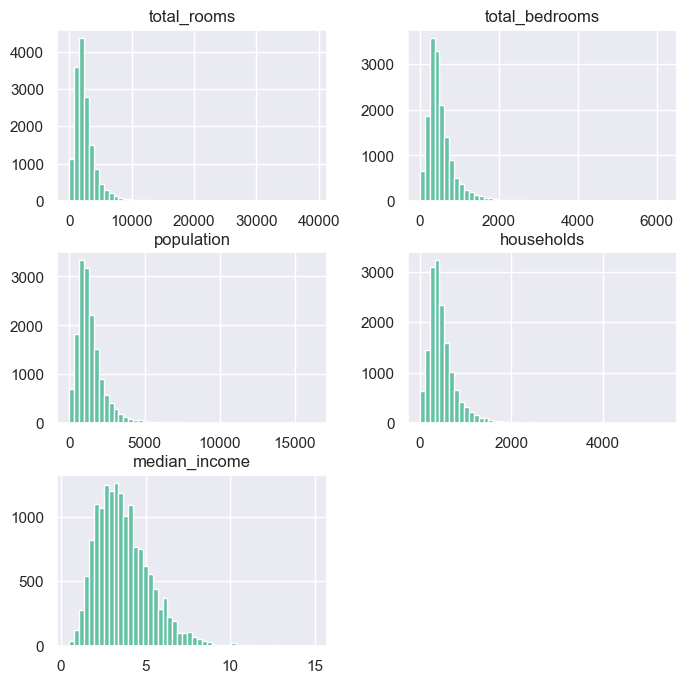

In [36]:
_ = trainset[["total_rooms", "total_bedrooms", "population", "households", "median_income"]].hist(bins=50, figsize=(8,8))

In [37]:
for col in ["total_rooms", "total_bedrooms", "population", "households", "median_income"]:
    trainset.loc[:, col] = np.log(trainset.loc[:, col] + 1)
    testset.loc[:, col] = np.log(testset.loc[:, col] + 1)

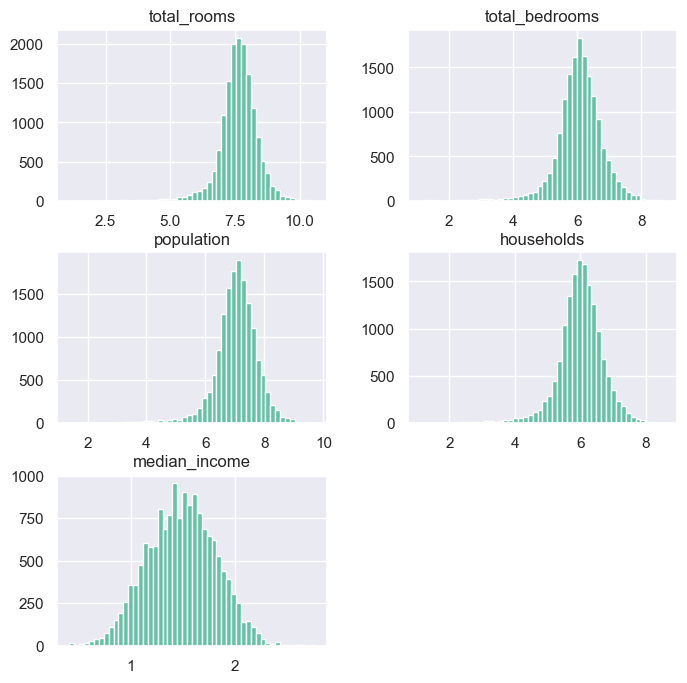

In [38]:
_ = trainset[["total_rooms", "total_bedrooms", "population", "households", "median_income"]].hist(bins=50, figsize=(8,8))

# Outlier detection

## Standard deviation method

In [39]:
from sklearn.base import OutlierMixin

class StdOutlierDetector(OutlierMixin):

    def __init__(self, threshold=3):
        self.threshold = threshold
        self.m, self.std = None, None

    def fit(self, X, y=None):
        self.m = X.mean()
        self.std = X.std()
        return self

    def predict(self, X, y=None):
        """Return -1 to indicate outliers, 1 to indicate inliers
        """
        z = np.abs((X - self.m) / self.std)
        return np.where((z <= self.threshold).all(axis=1), 1, -1)


Xtrain = np.array([[-1.1, -1.1], [0.2, 0.2], [1001.1, 0.2], [0.3, 1000.3]])
Xtest = np.array([[1, 1], [0.3, 900.3]])
clf = StdOutlierDetector(threshold=1)
yhat = clf.fit_predict(Xtrain)
yhat

array([ 1,  1, -1, -1])

In [40]:
yhat = clf.predict(Xtest)
yhat

array([ 1, -1])

In [41]:
ytrain = trainset["median_house_value"].copy()
Xtrain = trainset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()
Xtest = testset.drop("median_house_value", axis=1)

In [42]:
Xtrain.shape

(15735, 13)

In [43]:
Xtest.shape

(3940, 13)

In [44]:
# remove outliers in training set
clf = StdOutlierDetector(threshold=3)
yhat = clf.fit_predict(Xtrain)
Xtrain = Xtrain[yhat != -1]
ytrain = ytrain[yhat != -1]
Xtrain.shape

(15315, 13)

In [45]:
# remove outliers in test set
yhat = clf.predict(Xtest)
Xtest = Xtest[yhat == 1]
ytest = ytest[yhat != -1]
Xtest.shape

(3844, 13)

## IQR method

<Axes: >

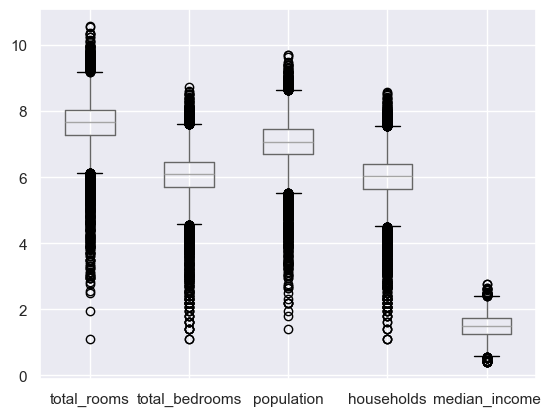

In [46]:
trainset.boxplot(column=["total_rooms", "total_bedrooms", "population", "households", "median_income"])

In [47]:
class IqrOutlierDetector(OutlierMixin):

    def __init__(self, factor=1.5):
        self.factor = factor
        self.upper, self.lower = None, None

    def fit(self, X, y=None):
        try:
            assert X.isnull().sum().sum() == 0
        except AttributeError:
            assert np.isnan(X).sum() == 0
        q25 = np.percentile(X, 25, axis=0)
        q75 = np.percentile(X, 75, axis=0)
        cut_off = (q75 - q25) * self.factor
        self.lower = q25 - cut_off
        self.upper = q75 + cut_off
        return self

    def predict(self, X, y=None):
        """Return -1 to indicate outliers, 1 to indicate inliers
        """
        return np.where(((X >= self.lower) & (X <= self.upper)).all(axis=1), 1, -1)

Xtrain = np.array([[-1.1, -1.1], [0.2, 0.2], [1001.1, 0.2], [0.3, 1000.3]])
Xtest = np.array([[1, 1], [0.3, 900.3]])
clf = IqrOutlierDetector()
yhat = clf.fit_predict(Xtrain)
yhat

array([ 1,  1, -1, -1])

In [48]:
yhat = clf.predict(Xtest)
yhat

array([ 1, -1])

In [49]:
ytrain = trainset["median_house_value"].copy()
Xtrain = trainset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()
Xtest = testset.drop("median_house_value", axis=1)

In [50]:
clf = IqrOutlierDetector()
yhat = clf.fit_predict(Xtrain)
Xtrain = Xtrain[yhat != -1]
ytrain = ytrain[yhat != -1]
Xtrain.shape

(10742, 13)

In [51]:
yhat = clf.predict(Xtest)
Xtest = Xtest[yhat == 1]
ytest = ytest[yhat != -1]
Xtest.shape

(2653, 13)

## Isolation Forest

In [52]:
ytrain = trainset["median_house_value"].copy()
Xtrain = trainset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()
Xtest = testset.drop("median_house_value", axis=1)

In [53]:
Xtrain.shape, Xtest.shape

((15735, 13), (3940, 13))

In [54]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, random_state=0, contamination=0.1).fit(Xtrain)
yhat = clf.predict(Xtrain)
Xtrain = Xtrain[yhat != -1]
ytrain = ytrain[yhat != -1]
Xtrain.shape

(14161, 13)

In [55]:
yhat = clf.predict(Xtest)
Xtest = Xtest[yhat == 1]
ytest = ytest[yhat != -1]
Xtest.shape

(3536, 13)

# Feature selection

In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression 

In [57]:
Xtrain.shape

(14161, 13)

In [58]:
selector = SelectKBest(r_regression, k=5)
Xtrain = selector.fit_transform(Xtrain, ytrain)
Xtest = selector.transform(Xtest)

In [59]:
Xtrain.shape

(14161, 5)

In [60]:
Xtest.shape

(3536, 5)

In [61]:
selector.get_feature_names_out()

array(['total_rooms', 'median_income', 'rooms_per_household',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype=object)

In [62]:
# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
Xtrain = pd.DataFrame(Xtrain, columns=selector.get_feature_names_out())
Xtest = pd.DataFrame(Xtest, columns=selector.get_feature_names_out())

# Feature scaling

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(Xtrain)
trainset = pd.DataFrame(scaled_vals, columns=Xtrain.columns)

# put the non-scaled target back in
trainset['median_house_value'] = ytrain

# inspect the data
trainset.head()

,total_rooms,median_income,rooms_per_household,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-0.401956,-0.451154,-0.499018,-0.31469,2.940486,NaN
1,-0.331693,0.371915,0.438519,-0.31469,2.940486,NaN
2,0.010823,0.373633,0.718285,-0.31469,-0.340080,NaN
3,-0.577730,0.129098,-0.855211,-0.31469,-0.340080,341300.0
4,0.297344,1.014585,0.562793,-0.31469,-0.340080,342200.0


In [64]:
scaled_vals = scaler.transform(Xtest)
testset = pd.DataFrame(scaled_vals, columns=Xtest.columns)

# put the non-scaled target back in
testset['median_house_value'] = ytest

testset.head()

,total_rooms,median_income,rooms_per_household,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,0.995936,-0.885681,-0.293318,-0.314690,-0.34008,NaN
1,1.849479,1.579280,0.629312,-0.314690,-0.34008,NaN
2,1.056769,0.986179,0.126450,3.177729,-0.34008,NaN
3,0.381319,-0.851326,-0.713093,-0.314690,-0.34008,NaN
4,-0.451080,-1.170034,-1.223911,-0.314690,-0.34008,NaN


# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm